In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_path = "Dataset/data" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.head()

,image,label
0,Dataset/data\Blight\CamScanner 04-11-2024 20.4...,Blight
1,Dataset/data\Blight\CamScanner 04-11-2024 20.4...,Blight
2,Dataset/data\Blight\CamScanner 04-11-2024 20.4...,Blight
3,Dataset/data\Blight\CamScanner 04-11-2024 20.4...,Blight
4,Dataset/data\Blight\CamScanner 04-11-2024 20.4...,Blight


In [4]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)


test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3399 validated image filenames belonging to 4 classes.
Found 399 validated image filenames belonging to 4 classes.
Found 399 validated image filenames belonging to 4 classes.


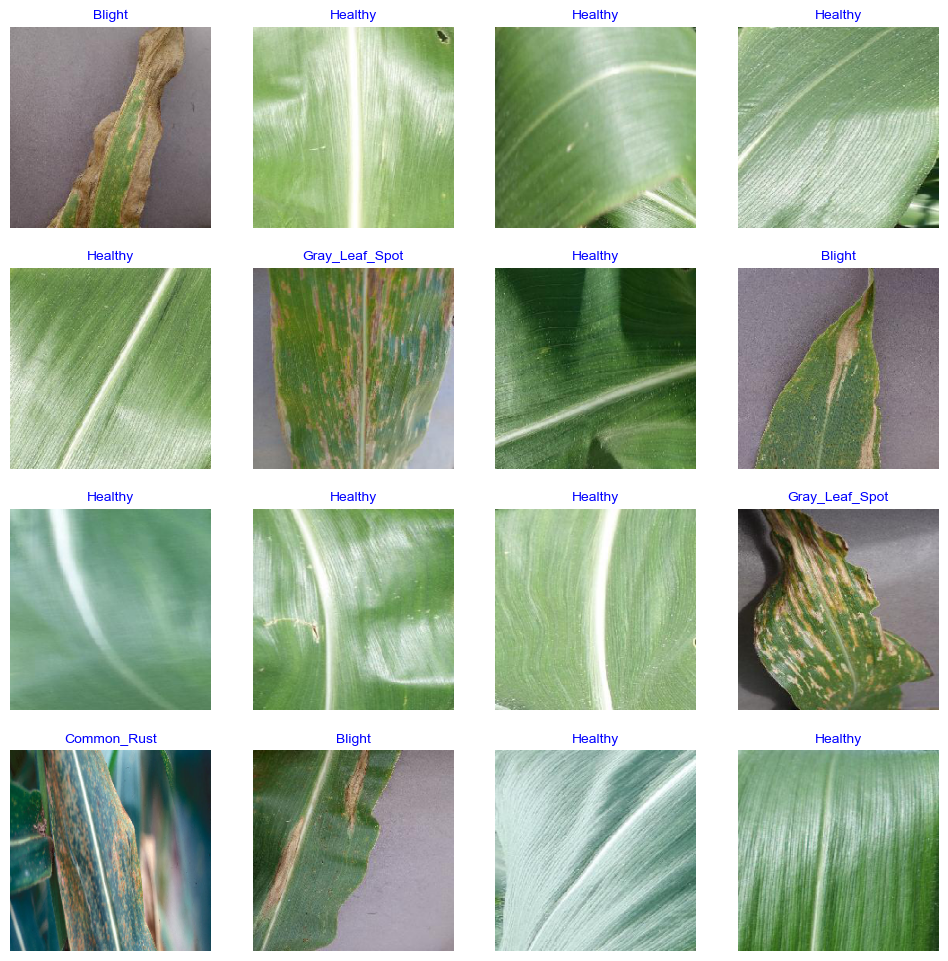

In [6]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

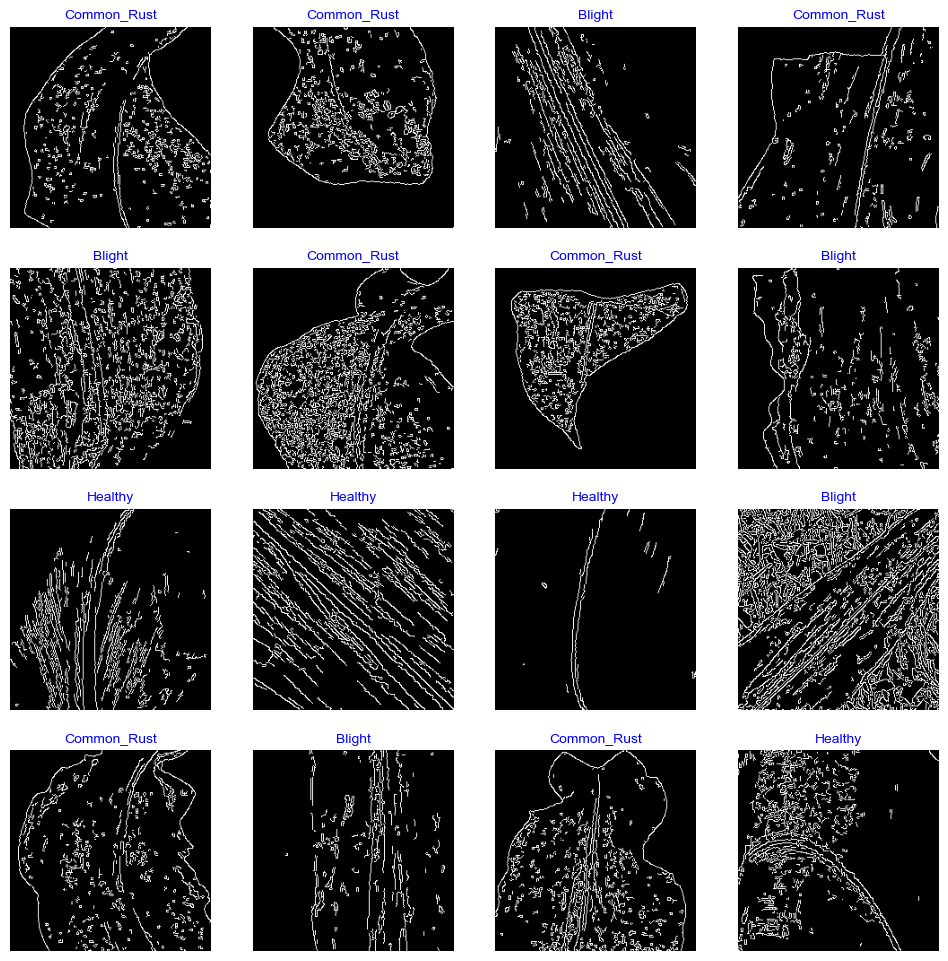

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_canny_edge_detection(image):
    if len(image.shape) == 3:  
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image
    
    gray_image = gray_image.astype(np.uint8)
    
    edges = cv2.Canny(gray_image, 100, 200)
    
    return edges

g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       

images, labels = next(train_gen)      

plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    
    edges = apply_canny_edge_detection(images[i])
    
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    
    plt.imshow(edges_rgb)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color='blue', fontsize=10)
    plt.axis('off')

plt.show()

In [8]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,147,140 (99.74 MB)

 Trainable params: 26,146,180 (99.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
model.save('model1.h5')

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='kaggle/working/model1.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "Dataset/data",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    "Dataset/data",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=valid_gen,
    callbacks=[early_stopping, checkpoint]
)

Found 4197 images belonging to 4 classes.
Found 4197 images belonging to 4 classes.
Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6898 - loss: 3.3593
Epoch 1: val_accuracy improved from -inf to 0.27734, saving model to kaggle/working/model1.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6902 - loss: 3.3503 - val_accuracy: 0.2773 - val_loss: 13.6893
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7778 - loss: 1.1545
Epoch 2: val_accuracy improved from 0.27734 to 0.47200, saving model to kaggle/working/model1.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.7779 - loss: 1.1532 - val_accuracy: 0.4720 - val_loss: 3.2384
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8090 - loss: 0.8314
Epoch 3: val_accuracy improved from 0.47200 to 0.56135, saving model to kaggle/working/model1.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.8091 - loss: 0.8310 - val_accuracy: 0.5614 - val_loss: 1.5753
Epoch 4/3

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/data\\Healthy\\Corn_Health (858).jpg'
Traceback (most recent call last):

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 247, in _finite_generator
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\Sion Pardosi\anaconda3\Lib\site-packages\keras\src\utils\image_utils.py", line 235, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/data\\Healthy\\Corn_Health (858).jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_4487]

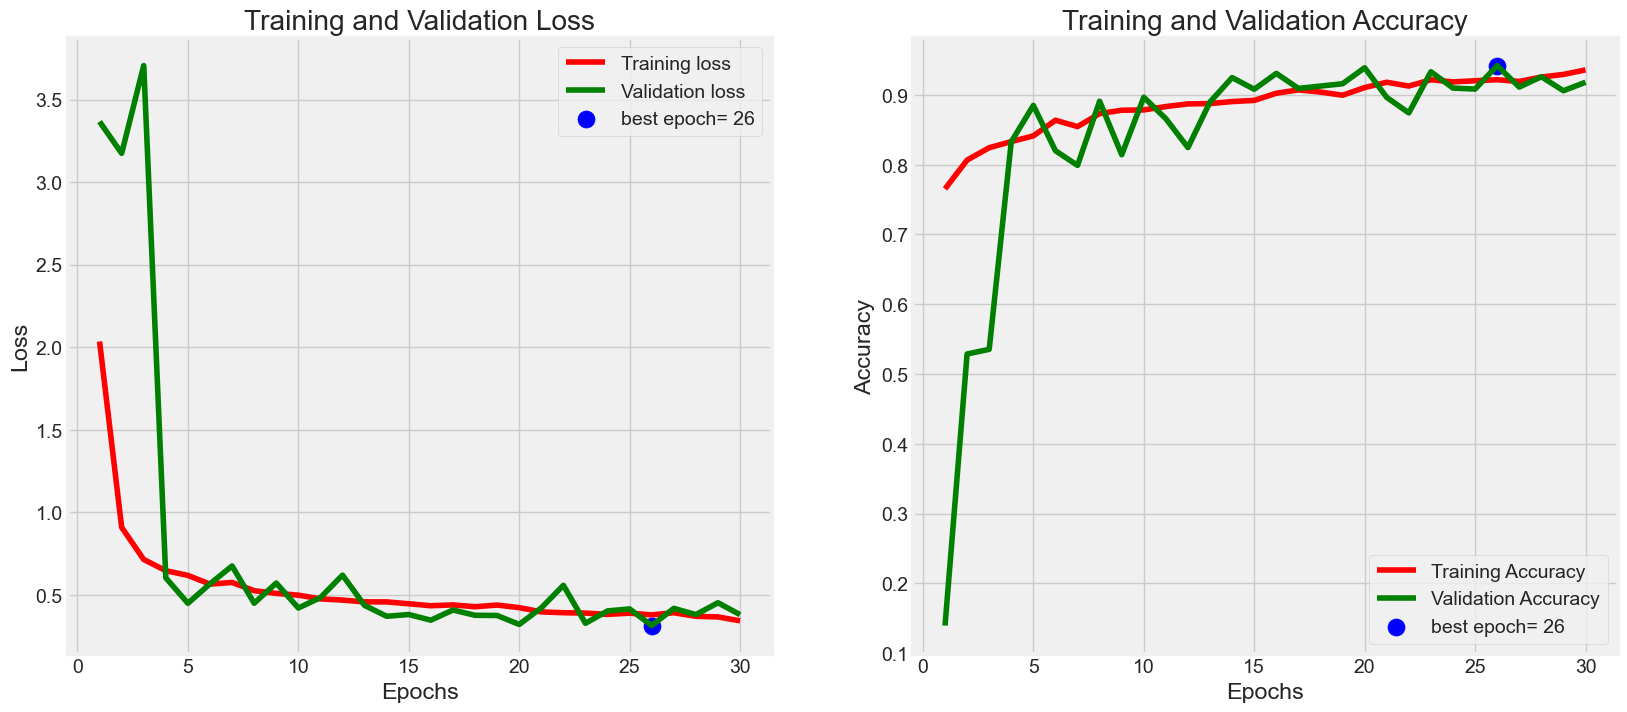

In [28]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [30]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

131/131 ━━━━━━━━━━━━━━━━━━━━ 52s 392ms/step - accuracy: 0.9429 - loss: 0.3004
Accuracy score: 0.9419770836830139


In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

def predict_image(model, img_path):
    # Load image dan ubah ukuran agar sesuai dengan input model
    img = image.load_img(img_path, target_size=(224, 224))

    # Mengubah gambar menjadi array
    img_array = image.img_to_array(img)

    # Menambahkan dimensi batch (batch_size = 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar (sesuai dengan preprocessing yang digunakan pada training)
    img_array = img_array / 255.0  # Normalisasi jika menggunakan ImageDataGenerator dengan rescale=1./255

    # Melakukan prediksi dengan model
    prediction = model.predict(img_array)

    # Menampilkan probabilitas untuk setiap kelas
    print(f"Probabilitas untuk setiap kelas: {prediction[0]}")

    return prediction

# Contoh pemakaian:
img_path = 'Dataset/data/Healthy/Corn_Health (1).jpg'  # Ganti dengan path gambar yang ingin diprediksi
prediction = predict_image(model, img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
Probabilitas untuk setiap kelas: [2.0327318e-06 9.9841584e-09 2.2337211e-07 9.9999774e-01]


In [68]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path):
    # Load image dan ubah ukuran agar sesuai dengan input model
    img = image.load_img(img_path, target_size=(224, 224))

    # Mengubah gambar menjadi array
    img_array = image.img_to_array(img)

    # Menambahkan dimensi batch (batch_size = 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar (sesuai dengan preprocessing yang digunakan pada training)
    img_array = img_array / 255.0  # Normalisasi jika menggunakan ImageDataGenerator dengan rescale=1./255

    # Melakukan prediksi dengan model
    prediction = model.predict(img_array)

    # Daftar label yang sesuai dengan indeks kelas
    class_labels = {0: 'hawar', 1: 'karat', 2: 'bercak', 3: 'sehat'}

    # Menampilkan probabilitas untuk setiap kelas dalam format persen
    print("Probabilitas untuk setiap kelas (dalam persen):")
    probabilities = prediction[0] * 100  # Mengubah ke persentase
    for i, prob in enumerate(probabilities):
        print(f"{class_labels[i]}: {prob:.2f}%")

    # Menentukan index kelas dengan probabilitas tertinggi
    predicted_index = np.argmax(prediction)

    # Menampilkan index dan probabilitas kelas yang diprediksi
    print(f'\nKelas yang diprediksi: {class_labels[predicted_index]} dengan probabilitas {probabilities[predicted_index]:.2f}%')

    return predicted_index, prediction

# Contoh pemakaian:
img_path = 'Dataset/data/Healthy/CamScanner 04-11-2024 20.46_3.jpg'  # Ganti dengan path gambar yang ingin diprediksi
predicted_index, prediction = predict_image(model, img_path) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Probabilitas untuk setiap kelas (dalam persen):
hawar: 0.06%
karat: 0.00%
bercak: 0.00%
sehat: 99.94%

Kelas yang diprediksi: sehat dengan probabilitas 99.94%
